# Fake news detection using ML 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score,classification_report,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
import os
data = pd.read_excel(
     os.path.join("data/set_antrenare.xlsx"),
     engine='openpyxl',
)

In [3]:
data.shape

(3119, 5)

## Data cleaning and preparation

In [4]:
# Check the data
data.head()

,Unnamed: 0,title,text,subcategory,label
0,0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,Facebook has shuttered a popular group for Mic...,false news,0
1,1,Other Viewpoints: COVID-19 is worse than the flu,We can now officially put to rest all comparis...,true,1
2,2,Bermuda's COVID-19 cases surpass 100,The Ministry of Health in Bermuda has confirme...,true,1
3,3,Purdue University says students face 'close to...,"Purdue University President Mitch Daniels, the...",partially false,0
4,4,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,Locking down much of the country may have help...,false news,0


In [5]:
# Removing the date (we won't use it for the analysis)
data.drop(["subcategory"],axis=1,inplace=True)
data["label"].replace({0: "fake", 1: "true"}, inplace=True)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,title,text,label
0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,Facebook has shuttered a popular group for Mic...,fake
1,Other Viewpoints: COVID-19 is worse than the flu,We can now officially put to rest all comparis...,true
2,Bermuda's COVID-19 cases surpass 100,The Ministry of Health in Bermuda has confirme...,true
3,Purdue University says students face 'close to...,"Purdue University President Mitch Daniels, the...",fake
4,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,Locking down much of the country may have help...,fake


In [6]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,label
0,Facebook has shuttered a popular group for Mic...,fake
1,We can now officially put to rest all comparis...,true
2,The Ministry of Health in Bermuda has confirme...,true
3,"Purdue University President Mitch Daniels, the...",fake
4,Locking down much of the country may have help...,fake


In [7]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,label
0,facebook has shuttered a popular group for mic...,fake
1,we can now officially put to rest all comparis...,true
2,the ministry of health in bermuda has confirme...,true
3,"purdue university president mitch daniels, the...",fake
4,locking down much of the country may have help...,fake


In [8]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [9]:
# Check
data.head()

,text,label
0,facebook has shuttered a popular group for mic...,fake
1,we can now officially put to rest all comparis...,true
2,the ministry of health in bermuda has confirme...,true
3,purdue university president mitch daniels the ...,fake
4,locking down much of the country may have help...,fake


In [10]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mihai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data.head()

,text,label
0,facebook shuttered popular group michiganders ...,fake
1,officially put rest comparisons covid19 influe...,true
2,ministry health bermuda confirmed newspaper re...,true
3,purdue university president mitch daniels form...,fake
4,locking much country may helped “flatten curve...,fake


## Basic data exploration

label
fake    1058
true    2061
Name: text, dtype: int64


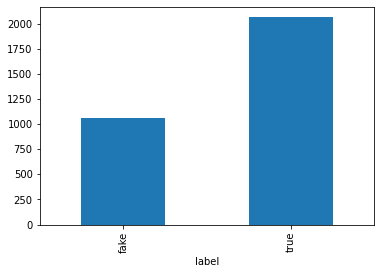

In [12]:
# How many fake and real articles?
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

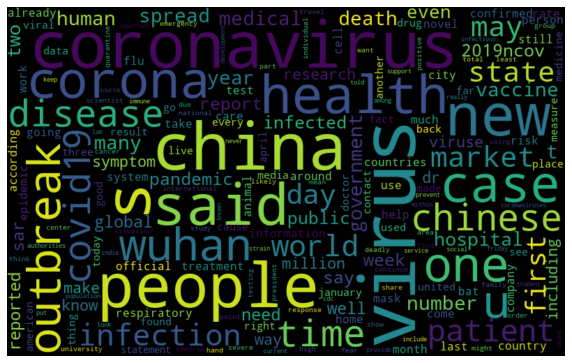

In [13]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["label"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

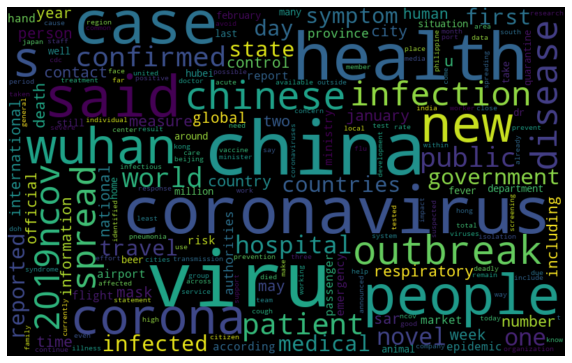

In [14]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["label"] == "true"]
all_words = ' '.join([text for text in real_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

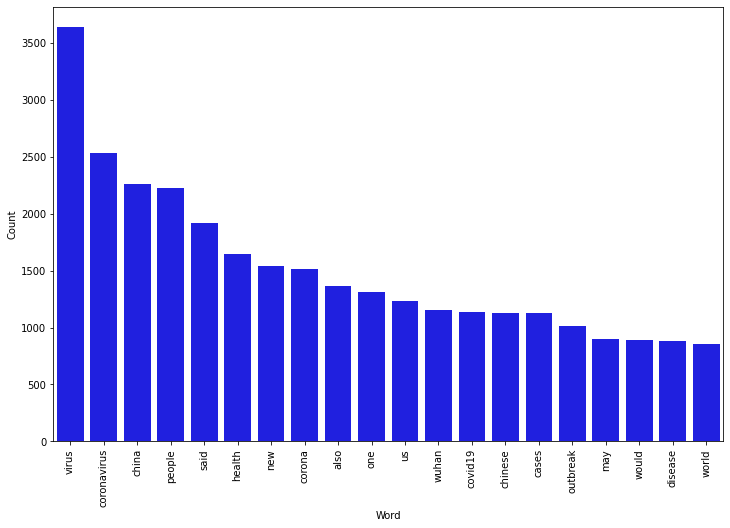

In [16]:
# Most frequent words in fake news
counter(data[data["label"] == "fake"], "text", 20)

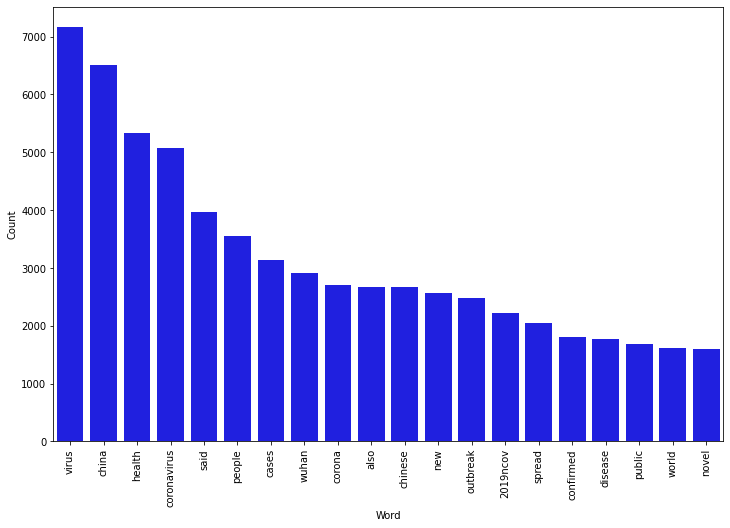

In [17]:
# Most frequent words in real news
counter(data[data["label"] == "true"], "text", 20)

## Modeling

In [18]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [19]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=42)

# **Naive Bayes**




In [20]:
dct = dict()
dct_p = dict()
dct_r = dict()
dct_f1 = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Naive Bayes'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Naive Bayes'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Naive Bayes'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 65.71%
precission: 65.42%
recall: 99.75%
F1 score: 79.02%
              precision    recall  f1-score   support

        fake       0.88      0.03      0.06       220
        true       0.65      1.00      0.79       404

    accuracy                           0.66       624
   macro avg       0.76      0.51      0.43       624
weighted avg       0.73      0.66      0.53       624



Confusion matrix, without normalization


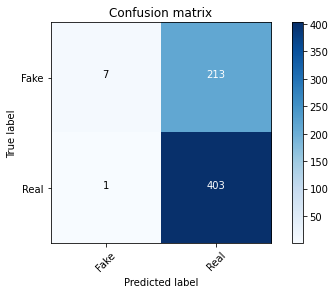

In [21]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [22]:

# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Logistic Regression'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Logistic Regression'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Logistic Regression'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 80.77%
precission: 80.21%
recall: 93.32%
F1 score: 86.27%
              precision    recall  f1-score   support

        fake       0.82      0.58      0.68       220
        true       0.80      0.93      0.86       404

    accuracy                           0.81       624
   macro avg       0.81      0.76      0.77       624
weighted avg       0.81      0.81      0.80       624



Confusion matrix, without normalization


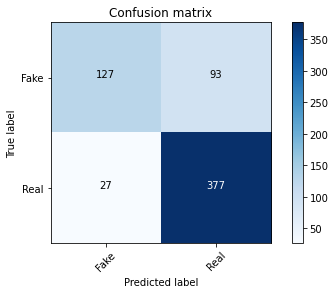

In [23]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [24]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Decision Tree'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Decision Tree'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Decision Tree'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 71.96%
precission: 79.74%
recall: 75.99%
F1 score: 77.82%
              precision    recall  f1-score   support

        fake       0.59      0.65      0.62       220
        true       0.80      0.76      0.78       404

    accuracy                           0.72       624
   macro avg       0.70      0.70      0.70       624
weighted avg       0.73      0.72      0.72       624



Confusion matrix, without normalization


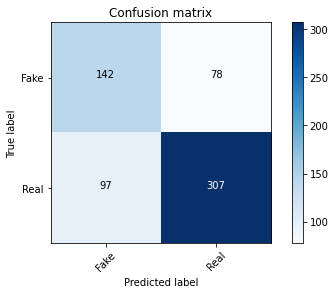

In [25]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [26]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Random Forest'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Random Forest'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Random Forest'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 79.01%
precission: 78.14%
recall: 93.81%
F1 score: 85.26%
              precision    recall  f1-score   support

        fake       0.82      0.52      0.64       220
        true       0.78      0.94      0.85       404

    accuracy                           0.79       624
   macro avg       0.80      0.73      0.74       624
weighted avg       0.80      0.79      0.78       624



Confusion matrix, without normalization


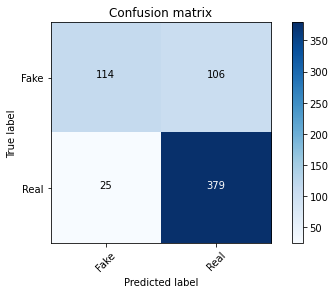

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [28]:

from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['SVM'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['SVM'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['SVM'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 80.61%
precission: 82.09%
recall: 89.6%
F1 score: 85.68%
              precision    recall  f1-score   support

        fake       0.77      0.64      0.70       220
        true       0.82      0.90      0.86       404

    accuracy                           0.81       624
   macro avg       0.80      0.77      0.78       624
weighted avg       0.80      0.81      0.80       624



Confusion matrix, without normalization


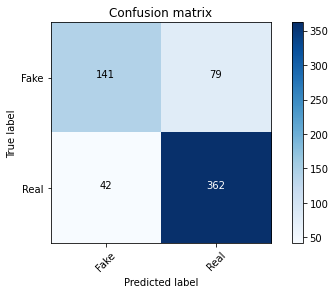

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **KNN**

In [30]:
from sklearn.neighbors import KNeighborsClassifier

#Create a svm Classifier
knn = KNeighborsClassifier(n_neighbors = 3)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', knn)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['KNN'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['KNN'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['KNN'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['KNN'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 75.48%
precission: 76.87%
recall: 88.86%
F1 score: 82.43%
              precision    recall  f1-score   support

        fake       0.71      0.51      0.59       220
        true       0.77      0.89      0.82       404

    accuracy                           0.75       624
   macro avg       0.74      0.70      0.71       624
weighted avg       0.75      0.75      0.74       624



Confusion matrix, without normalization


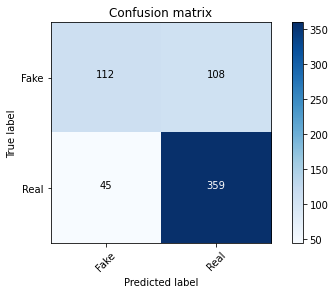

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

Text(0.5, 1.0, 'Accuracy')

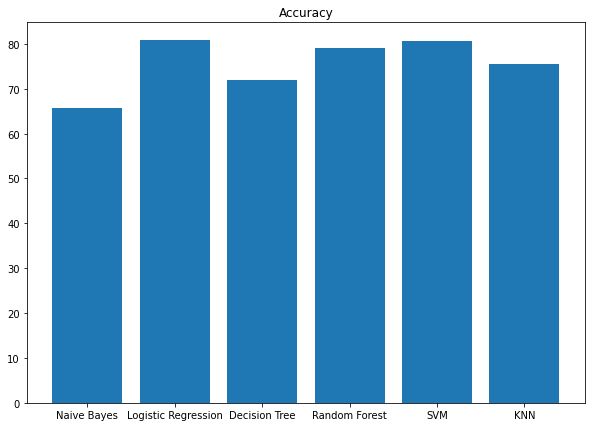

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.title('Accuracy')

Text(0.5, 1.0, 'Precision')

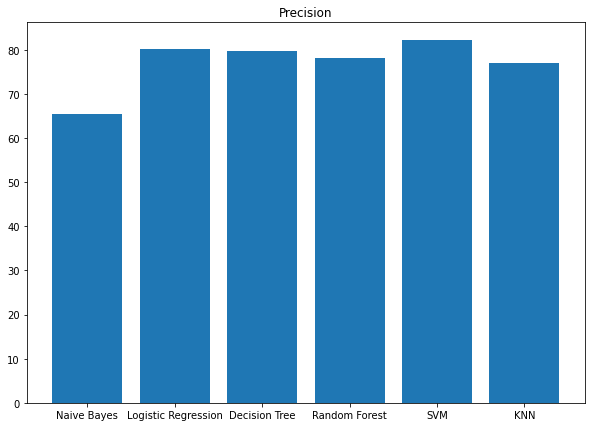

In [33]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_p.keys()),list(dct_p.values()))
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

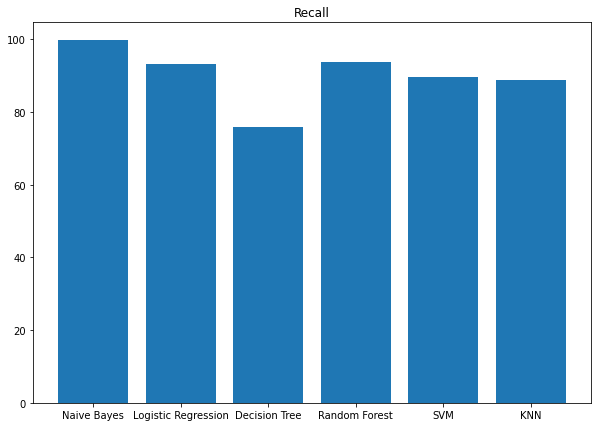

In [34]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_r.keys()),list(dct_r.values()))
plt.title('Recall')

Text(0.5, 1.0, 'F1 Score')

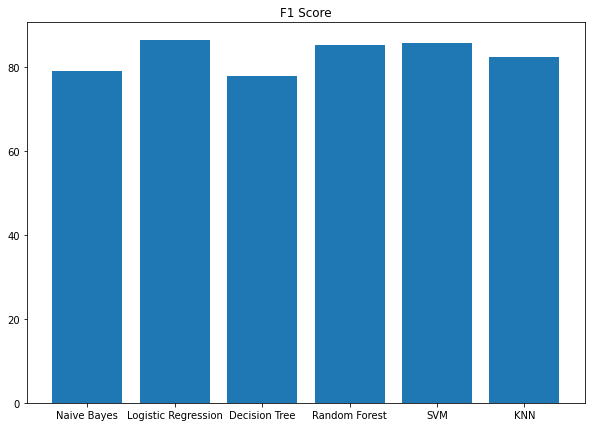

In [35]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_f1.keys()),list(dct_f1.values()))
plt.title('F1 Score')